In [ ]:
!pip install simpletransformers

In [ ]:
!pip install wandb

In [ ]:
!pip install nltk

In [ ]:
!pip install rouge-score

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from simpletransformers.question_answering import QuestionAnsweringModel
import wandb
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

In [ ]:
# Load the dataset
medquad_df = pd.read_csv("train.csv")

In [ ]:
medquad_df.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


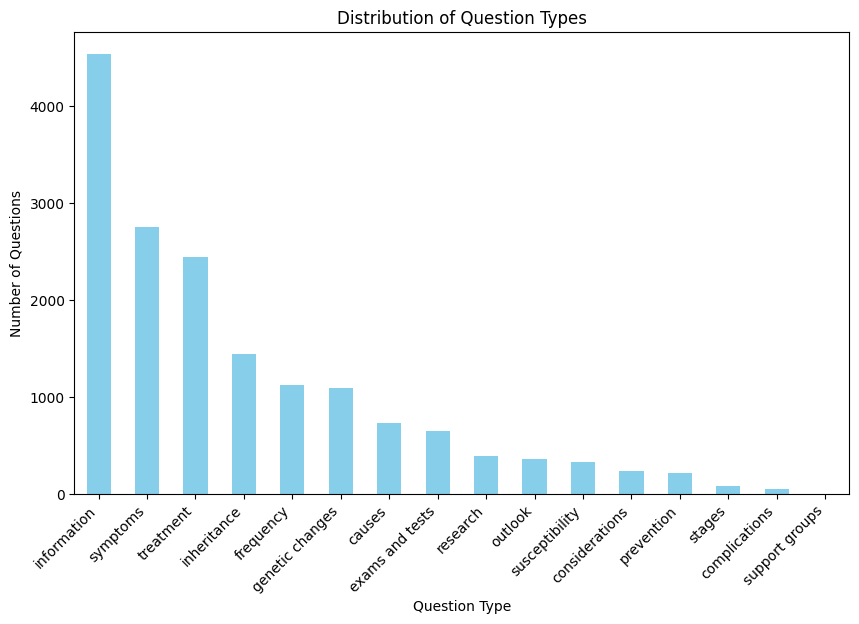

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'qtype' is the column containing question types in medquad_df

# Count the occurrences of each question type
qtype_counts = medquad_df['qtype'].value_counts()

# Plot the distribution of question types
plt.figure(figsize=(10, 6))
qtype_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Question Types')
plt.xlabel('Question Type')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45, ha='right')
plt.show()

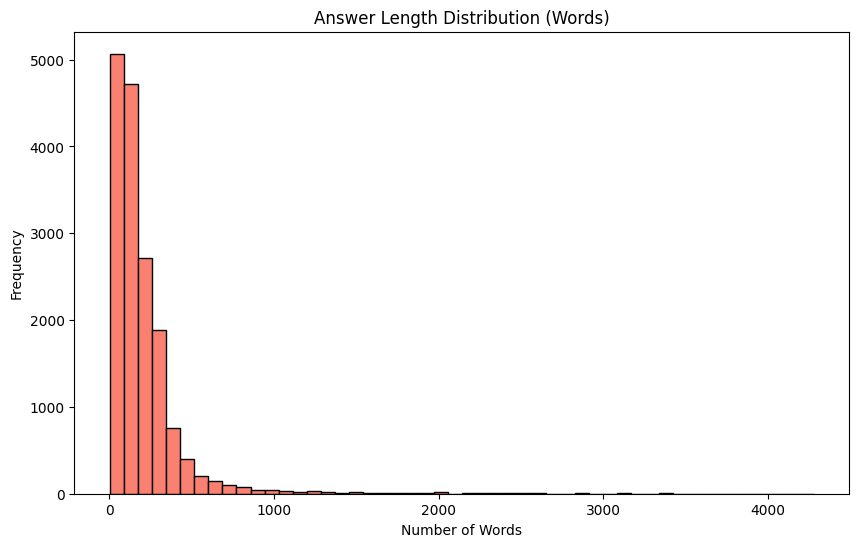

In [ ]:
# Assuming 'Answer' is the column containing answers in medquad_df

# Calculate the length of each answer in terms of words
medquad_df['Answer_Length_Words'] = medquad_df['Answer'].str.split().apply(len)

# Visualize the distribution of answer lengths
plt.figure(figsize=(10, 6))
plt.hist(medquad_df['Answer_Length_Words'], bins=50, color='salmon', edgecolor='black')
plt.title('Answer Length Distribution (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Load your training dataset into a pandas DataFrame
train_df = medquad_df

# Process the DataFrame to create a list of examples in the required format
train_data = []
for idx, row in train_df.iterrows():
    context = row["qtype"]
    question = row["Question"]
    answer = row["Answer"]

    # Create the example dictionary
    example = {
        "context": context,
        "qas": [
            {
                "question": question,
                "id": str(idx),  # Unique identifier for the example
                "answers": [{"text": answer, "answer_start": 0}]  # Assuming answer_start is 0
            }
        ]
    }
    train_data.append(example)

In [ ]:
# Split the dataset into training and testing sets (75% training, 25% testing)
train_df, test_df = train_test_split(train_data, test_size=0.25, random_state=42)

# Initialize wandb for logging training visualization
wandb.init(project="medquad-question-answering")

# Define hyperparameters and model configurations
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "learning_rate": 2e-5,
    "num_train_epochs": 2,
    "max_seq_length": 256,
    "doc_stride": 64,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "wandb_project": "medquad-question-answering"
}

# Fine-tune BERT model
bert_model = QuestionAnsweringModel(
    "bert", "bert-base-uncased", args=model_args
)
bert_model.train_model(train_df)

# Fine-tune MobileBERT model
mobilebert_model = QuestionAnsweringModel(
    "mobilebert", "google/mobilebert-uncased", args=model_args
)
mobilebert_model.train_model(train_df)

# Fine-tune RoBERTa model
roberta_model = QuestionAnsweringModel(
    "roberta", "roberta-base", args=model_args
)
roberta_model.train_model(train_df)

# Evaluate the models on the testing data
bert_results = bert_model.eval_model(test_df)
mobilebert_results = mobilebert_model.eval_model(test_df)
roberta_results = roberta_model.eval_model(test_df)

# Calculate BLEU Score and Rouge Scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def calculate_rouge_scores(hypotheses, references):
    rouge_scores = scorer.score(hypotheses, references)
    return rouge_scores

# Example usage
references = test_df['Answer'].tolist()
hypotheses_bert = bert_results['correct_text'].tolist()
hypotheses_mobilebert = mobilebert_results['correct_text'].tolist()
hypotheses_roberta = roberta_results['correct_text'].tolist()

rouge_scores_bert = calculate_rouge_scores(hypotheses_bert, references)
rouge_scores_mobilebert = calculate_rouge_scores(hypotheses_mobilebert, references)
rouge_scores_roberta = calculate_rouge_scores(hypotheses_roberta, references)

# Calculate BLEU score
references_tokenized = [ref.split() for ref in references]
hypotheses_tokenized_bert = [hyp.split() for hyp in hypotheses_bert]
hypotheses_tokenized_mobilebert = [hyp.split() for hyp in hypotheses_mobilebert]
hypotheses_tokenized_roberta = [hyp.split() for hyp in hypotheses_roberta]

bleu_score_bert = corpus_bleu(references_tokenized, hypotheses_tokenized_bert)
bleu_score_mobilebert = corpus_bleu(references_tokenized, hypotheses_tokenized_mobilebert)
bleu_score_roberta = corpus_bleu(references_tokenized, hypotheses_tokenized_roberta)

# Print evaluation metrics
print("Evaluation Metrics:")
print("BERT Rouge Scores:", rouge_scores_bert)
print("MobileBERT Rouge Scores:", rouge_scores_mobilebert)
print("RoBERTa Rouge Scores:", rouge_scores_roberta)
print("BERT BLEU Score:", bleu_score_bert)
print("MobileBERT BLEU Score:", bleu_score_mobilebert)
print("RoBERTa BLEU Score:", bleu_score_roberta)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
convert squad examples to features:   0%|          | 0/12305 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible w